The problem with my w(\theta) calculation appears to be fairly fundamental: calculating in a snapshot just gives very strange answers. I'm gonna try directly integratng the 3-d correlation function. I'm gonna try doing that directly, but it is possible that I'll have to emulate to get that quite right. 

There is a prefactor which I'm going to compute directly from the redMagic data that I have. 

In [33]:
from pearce.mocks import cat_dict
import numpy as np
from os import path
from astropy.io import fits
from astropy import constants as const, units as unit

In [34]:
import george
from george.kernels import ExpSquaredKernel

In [35]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Load up the tptY3 buzzard mocks. 

In [36]:
fname = '/u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits'
hdulist = fits.open(fname)

In [37]:
z_bins = np.array([0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
zbin=1

In [38]:
a = 0.81120
z = 1.0/a - 1.0

Load up a snapshot at a redshift near the center of this bin. 

In [39]:
print z

0.232741617357


This code load a particular snapshot and and a particular HOD model. In this case, 'redMagic' is the Zheng07 HOD with the f_c variable added in.

In [40]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#cat.h = 1.0
#halo_masses = cat.halocat.halo_table['halo_mvir']

In [41]:
cat.load_model(a, 'redMagic')

In [42]:
hdulist.info()

Filename: /u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1  xip         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  2  xim         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  3  gammat      BinTableHDU     32   400R x 5C   [K, K, K, D, D]   
  4  wtheta      BinTableHDU     32   300R x 5C   [K, K, K, D, D]   
  5  nz_shear_bpz  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  6  nz_shear_true  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  7  nz_pos_zrm  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   
  8  nz_pos_zspec  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   


In [43]:
print hdulist[4].data

[(1, 1,  0,   4.56957466e-01,    2.82362129)
 (1, 1,  1,   3.62154907e-01,    3.55714603)
 (1, 1,  2,   2.90411390e-01,    4.48237938)
 (1, 1,  3,   2.31183177e-01,    5.64007306)
 (1, 1,  4,   1.91003284e-01,    7.10466107)
 (1, 1,  5,   1.51002997e-01,    8.94410971)
 (1, 1,  6,   1.31082683e-01,   11.26263824)
 (1, 1,  7,   1.07493532e-01,   14.17700893)
 (1, 1,  8,   8.68005526e-02,   17.84769873)
 (1, 1,  9,   7.52830226e-02,   22.47191605)
 (1, 1, 10,   6.29119489e-02,   28.28898196)
 (1, 1, 11,   5.18914870e-02,   35.61410283)
 (1, 1, 12,   4.11548751e-02,   44.834109  )
 (1, 1, 13,   3.02333987e-02,   56.44753572)
 (1, 1, 14,   2.22349777e-02,   71.06401175)
 (1, 1, 15,   1.57940000e-02,   89.4625058 )
 (1, 1, 16,   1.05595053e-02,  112.62320328)
 (1, 1, 17,   6.70239819e-03,  141.77573475)
 (1, 1, 18,   4.53896752e-03,  178.48268026)
 (1, 1, 19,   2.66568363e-03,  224.66013317)
 (1, 2,  0,   6.26817874e-02,    2.82904072)
 (1, 2,  1,   4.63055589e-02,    3.56044312)
 (1, 2,  2

Take the zspec in our selected zbin to calculate the dN/dz distribution. The below cell calculate the redshift distribution prefactor

$$ W = \frac{2}{c}\int_0^{\infty} dz H(z) \left(\frac{dN}{dz} \right)^2 $$

In [69]:
nz_zspec = hdulist[8]
#N = 0#np.zeros((5,))
N_total =  np.sum([row[2+zbin] for row in nz_zspec.data])
dNdzs = [] 
zs = []
W = 0 
for row in nz_zspec.data:

    N = row[2+zbin]
    
    dN = N*1.0/N_total
    
    #volIn, volOut = cat.cosmology.comoving_volume(row[0]), cat.cosmology.comoving_volume(row[2])

    #fullsky_volume = volOut-volIn
    #survey_volume = fullsky_volume*area/full_sky
    #nd = dN/survey_volume
    
    dz = row[2] - row[0]
    print dz
    dNdz = dN/dz
        
    H = cat.cosmology.H(row[1])
        
    W+= dz*H*(dNdz)**2
    
    dNdzs.append(dNdz)
    zs.append(row[1])
    
    
    #for idx, n in enumerate(row[3:]):
    #    N[idx]+=n
W = 2*W/const.c

print W

0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01


Verify that our dN/dz looks appropriate.

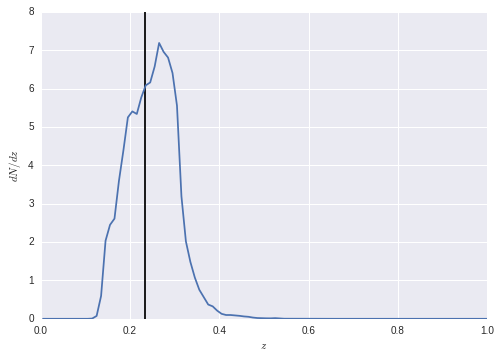

In [45]:
plt.plot(zs, dNdzs)
plt.vlines(z, 0,8)
plt.xlim(0,1.0)
plt.xlabel(r'$z$')
plt.ylabel(r'$dN/dz$')

In [65]:
len(nz_zspec.data)

400

In [68]:
np.sum(dNdzs)

100.0

In [46]:
np.sum(dNdzs)/len(nz_zspec.data)

0.25

In [47]:
W.to(1/unit.Mpc)

<Quantity 0.0027584807220739026 1 / Mpc>

If we happened to choose a model with assembly bias, set it to 0. Leave all parameters as their defaults, for now. 

In [48]:
params = cat.model.param_dict.copy()
params['mean_occupation_centrals_assembias_param1'] = 0.0
params['mean_occupation_satellites_assembias_param1'] = 0.0
#params['logMmin'] = 12.5
#params['sigma_logM'] = 0.43
#params['f_c'] = 0.2
#params['alpha'] = 1.1
#params['logM1'] = 13.3
#params['logM0'] = params['logMmin']

print params

{'logM1': 13.7, 'mean_occupation_satellites_assembias_param1': 0.0, 'logMmin': 12.1, 'mean_occupation_centrals_assembias_param1': 0.0, 'f_c': 0.19, 'logM0': 12.2, 'sigma_logM': 0.46, 'alpha': 1.02}


In [49]:
cat.populate(params)

In [50]:
theta_bins = np.logspace(np.log10(0.004), 0, 24)#/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [51]:
r_bins = np.logspace(-1.5, 1.7, 24)
rpoints = (r_bins[1:]+r_bins[:-1])/2

Use my code's wrapper for halotools' xi calculator. Full source code can be found [here](https://github.com/mclaughlin6464/pearce/blob/31e2f6a3598217dcf1be3d2606b69c4e529fc791/pearce/mocks/cat.py#L688).

In [52]:
xi = cat.calc_xi(r_bins, do_jackknife=False)

Interpolate with a Gaussian process. May want to do something else "at scale", but this is quick for now. 

In [53]:
kernel = ExpSquaredKernel(0.05)
gp = george.GP(kernel)
gp.compute(np.log10(rpoints))

In [54]:
print xi

[  7.72411497e+03   4.01023145e+03   2.16333998e+03   1.36646934e+03
   8.25627289e+02   4.68078906e+02   2.61817010e+02   1.39944181e+02
   7.22715791e+01   3.67274194e+01   1.63693068e+01   7.97226558e+00
   4.19208184e+00   2.38952479e+00   1.45368182e+00   9.16485850e-01
   5.67015449e-01   3.12330600e-01   1.82590407e-01   9.56744616e-02
   4.55257950e-02   1.79827733e-02   4.56258594e-03]


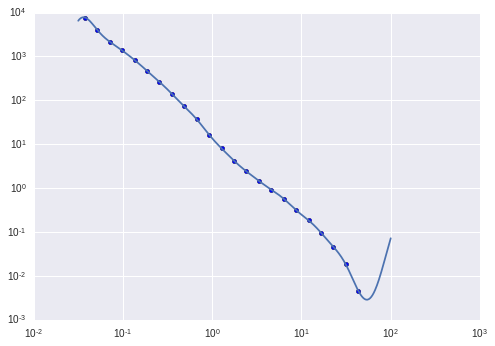

In [55]:
rpoints_dense = np.logspace(-1.5, 2, 500)

plt.scatter(rpoints, xi)
plt.plot(rpoints_dense, np.power(10, gp.predict(np.log10(xi), np.log10(rpoints_dense))[0]))
plt.loglog();

This plot looks bad on large scales. I will need to implement a linear bias model for larger scales; however I believe this is not the cause of this issue. The overly large correlation function at large scales if anything should increase w(theta). 

This plot shows the regimes of concern. The black lines show the value of r for u=0 in the below integral for each theta bin. The red lines show the maximum value of r for the integral I'm performing.

In [56]:
theta_bins_rm = np.logspace(np.log10(2.5), np.log10(250), 21)/60 #binning used in buzzard mocks
tpoints_rm = (theta_bins_rm[1:]+theta_bins_rm[:-1])/2.0

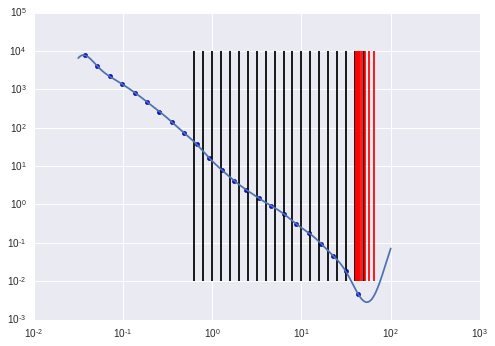

In [57]:
rpoints_dense = np.logspace(-1.5, 2, 500)
x = cat.cosmology.comoving_distance(z)

plt.scatter(rpoints, xi)
plt.plot(rpoints_dense, np.power(10, gp.predict(np.log10(xi), np.log10(rpoints_dense))[0]))
plt.vlines((a*x*np.radians(tpoints_rm)).value, 1e-2, 1e4)
plt.vlines((a*np.sqrt(x**2*np.radians(tpoints_rm)**2+unit.Mpc*unit.Mpc*10**(1.7*2))).value, 1e-2, 1e4, color = 'r')

plt.loglog();

Perform the below integral in each theta bin:

$$ w(\theta) = W \int_0^\infty du \xi \left(r = \sqrt{u^2 + \bar{x}^2(z)\theta^2} \right) $$

Where $\bar{x}$ is the median comoving distance to z. 

In [58]:
wt = np.zeros_like(tpoints_rm)
x = cat.cosmology.comoving_distance(z)
#ubins = np.linspace(10**-6, 10**2.0, 1001)
ubins = np.logspace(-6, 2.0, 101)

ubc = (ubins[1:]+ubins[:-1])/2.0
for bin_no, t_med in enumerate(np.radians(tpoints_rm)):
    int_xi = 0
    for ubin_no, _u in enumerate(ubc):
        _du = ubins[ubin_no+1]-ubins[ubin_no]
        u = _u*unit.Mpc
        du = _du*unit.Mpc
        r = a*np.sqrt((u**2+(x*t_med)**2).value)#*cat.h#not sure about the h
        if r > 10**1.7: #ignore large scales. In the full implementation this will be a transition to a bias model. 
            int_xi+=du*0
        else:
            # the GP predicts in log, so i predict in log and re-exponate
            int_xi+=du*(np.power(10, \
                    gp.predict(np.log10(xi), np.log10(r), mean_only=True)[0]))
    wt[bin_no] = int_xi*W

In [59]:
print x

944.909402664 Mpc


In [60]:
#a subset of the data from above. I've verified it's correct, but we can look again. 
wt_redmagic = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_%d%d.npy'%(zbin,zbin))

In [61]:
tpoints_rm

array([ 0.04706095,  0.05924622,  0.07458657,  0.09389893,  0.11821175,
        0.14881978,  0.187353  ,  0.23586345,  0.2969345 ,  0.37381838,
        0.47060946,  0.59246221,  0.74586573,  0.93898932,  1.18211752,
        1.48819778,  1.87353001,  2.35863454,  2.96934496,  3.73818382])

The below plot shows the problem. There appears to be a constant multiplicative offset between the redmagic calculation and the one we just performed. The plot below it shows their ratio. It is near-constant, but there is some small radial trend. Whether or not it is significant is tough to say. 

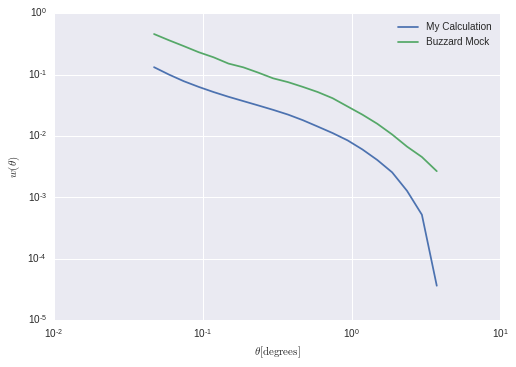

In [62]:
plt.plot(tpoints_rm, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

(3.0, 4)

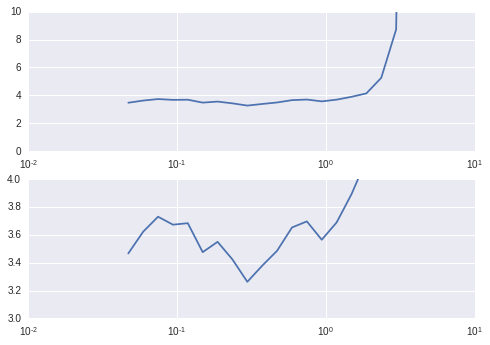

In [63]:
plt.subplot(211)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
plt.ylim([0,10])
plt.subplot(212)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
plt.ylim([3.0,4])

The below cell calculates the integrals jointly instead of separately. It doesn't change the results significantly, but is quite slow. I've disabled it for that reason. 

In [64]:
plt.plot(tpoints_rm, wt2, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

NameError: name 'wt2' is not defined

In [ ]:
wt_redmagic/wt2